In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sklearn.preprocessing
from tqdm import tqdm

In [3]:
sns.set_theme(style="white")

In [6]:
PATH = "D:/Projects/3W/dataset/"
NORMAL_CLASS = 0
# In this case, we will consider the benchmark proposed by Vargas (2019), with real instances that have windows of more 
# than 20 minutes.
ABNORMAL_CLASSES = [1, 2, 5, 6, 7, 8]

In [12]:
files = []

for file in os.listdir( os.path.join(PATH, str(NORMAL_CLASS)) ):
    file_path = os.path.join(PATH, str(NORMAL_CLASS), file)
    if "WELL" not in file_path:
        continue
        
    files.append(file_path)

In [13]:
data = pd.DataFrame()

for file in files:
    if len(files) > 20:
        break
    
    temp_data = pd.read_csv(file)
    data = pd.concat([data, temp_data])

In [14]:
data["timestamp"] = pd.to_datetime(data["timestamp"])
data = data.set_index("timestamp")

data = data.drop("class", axis=1)
data = data.fillna(0)

In [18]:
# Resample data for 5 second interval
data = data.resample('5S').mean()

In [15]:
scaler = sklearn.preprocessing.StandardScaler()
preprocessed_data = scaler.fit_transform(data)
preprocessed_data = pd.DataFrame(data=preprocessed_data, columns=data.columns)

Text(0.5, 1.0, 'TPT Pressure')

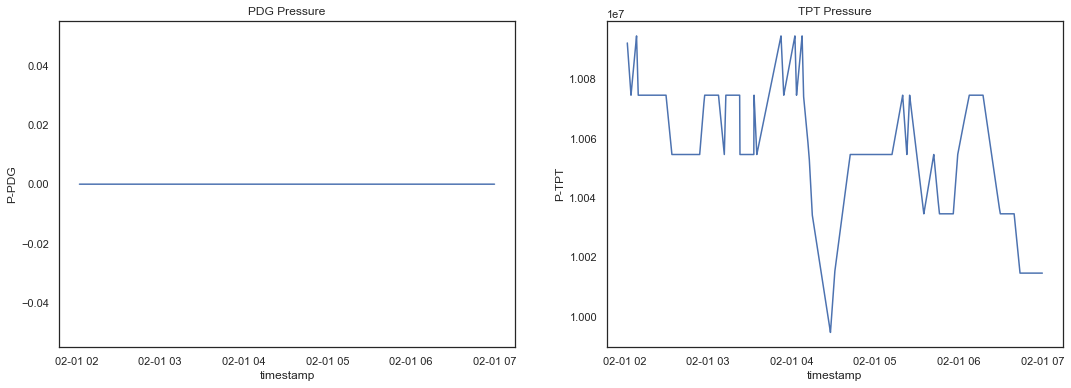

In [16]:
f, ax = plt.subplots(ncols=2, figsize=(18, 6))
sns.lineplot(data=data["P-PDG"], ax=ax[0])
sns.lineplot(data=data["P-TPT"], ax=ax[1])
ax[0].set_title("PDG Pressure")
ax[1].set_title("TPT Pressure")

<AxesSubplot:xlabel='timestamp', ylabel='T-JUS-CKP'>

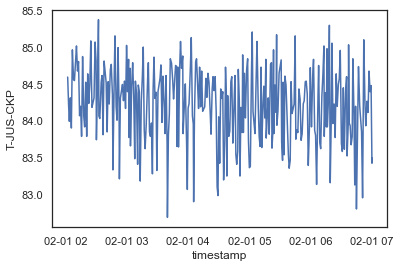

In [14]:
sns.lineplot(x="timestamp", y="T-JUS-CKP", data=data)

<AxesSubplot:xlabel='timestamp', ylabel='P-JUS-CKGL'>

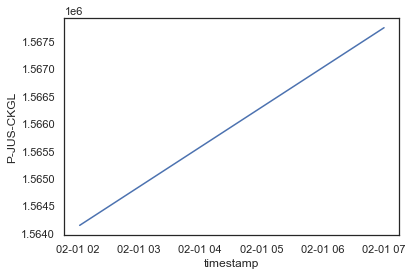

In [17]:
sns.lineplot(x="timestamp", y="P-JUS-CKGL", data=data)

In [16]:
STEPS = 10

In [17]:
def create_sequence(data, steps=STEPS):
    xs, ys = [], []
    for i in tqdm(range(len(data) - steps)):
        xs.append(data.iloc[i:(i+steps)].values)
        ys.append(data.iloc[i+steps].values)
        
    return np.array(xs), np.array(ys)

In [18]:
x_train, y_train = create_sequence(preprocessed_data)

100%|██████████| 382435/382435 [00:35<00:00, 10664.47it/s]


In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.RepeatVector(x_train.shape[1]))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.Dropout(rate=0.1))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(x_train.shape[2])))

opt = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=opt, loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               70144     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 10, 128)          0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 10, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 10, 128)           0         
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 8)            1032      
 tributed)                                            

In [20]:
y_train = y_train.reshape(y_train.shape[0], 1, 8)

In [25]:
h = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.3,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/5
8366/8366 [==============================] - 190s 22ms/step - loss: 0.0554 - val_loss: 0.1489
Epoch 2/5
8366/8366 [==============================] - 199s 24ms/step - loss: 0.0282 - val_loss: 0.1504
Epoch 3/5
8366/8366 [==============================] - 202s 24ms/step - loss: 0.0224 - val_loss: 0.1129
Epoch 4/5
8366/8366 [==============================] - 227s 27ms/step - loss: 0.0196 - val_loss: 0.1588
Epoch 5/5
8366/8366 [==============================] - 178s 21ms/step - loss: 0.0191 - val_loss: 0.2237


Text(0, 0.5, 'MAE')

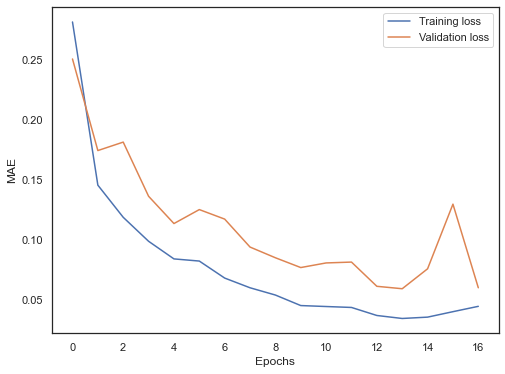

In [31]:
plt.figure(figsize=(8,6))
plt.plot(h.history['loss'], label='Training loss')
plt.plot(h.history['val_loss'], label='Validation loss')
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("MAE")

In [26]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

11952/11952 [==============================] - 66s 5ms/step


In [32]:
threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Reconstruction error threshold: 1.4236607900021816


### Test

In [60]:
test_data = pd.read_csv(r"D:/Projects/3W/dataset/1/WELL-00006_20170801063614.csv")

test_data["timestamp"] = pd.to_datetime(test_data["timestamp"])
test_data = test_data.set_index("timestamp")

# Resample data for 5 second interval
#test_data = test_data.resample('5S').mean()

test_data = test_data.drop("class", axis=1)
preprocessed_test_data = scaler.transform(test_data)

preprocessed_test_data = pd.DataFrame(data=preprocessed_test_data, columns=data.columns)
preprocessed_test_data = preprocessed_test_data.fillna(0)

In [54]:
x_test, y_test = create_sequence(preprocessed_test_data)

100%|██████████| 49384/49384 [00:06<00:00, 8123.71it/s] 


In [55]:
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

1544/1544 [==============================] - 11s 7ms/step


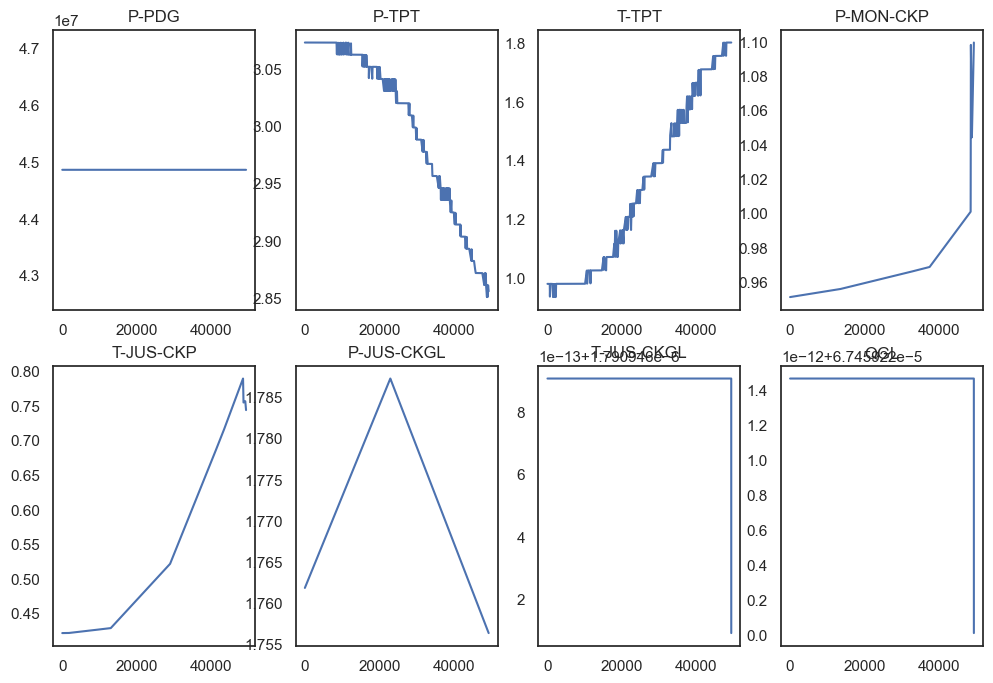

In [56]:
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
for i in range(2):
    for j in range(4):
        ax[i][j].plot(test_mae_loss[:, i*4 + j])
        ax[i][j].set_title(data.columns[i*4 + j])

In [69]:
test_data = pd.concat([test_data.reset_index(), pd.Series((test_mae_loss > threshold).any(axis=1), name="anomaly")], axis=1)